In [2]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
# Returns gaussian distributed fourier coefficients as a function of wavenumber for a narrow-banded process
def A(k_0,l_0,A_0,sigma_k,kk,ll):
    return A_0*np.exp(-((kk-k_0)**2 + (ll-l_0)**2)/(sigma_k**2))

In [4]:
# Generates noise by applying random phases to the cosine part of each wave component
def generate_unmasked_noise(k_0,l_0,xx,yy,sigma_k,A_0):
    pi = np.pi
    
    # Pick a range of wavenumbers
    ks = np.linspace(k_0 - np.rint(4*sigma_k),k_0 + np.rint(4*sigma_k))
    ls = np.linspace(l_0 - np.rint(4*sigma_k),l_0 + np.rint(4*sigma_k))
    ks = np.linspace(0,2*k_0)
    ls = np.linspace(0,2*l_0)
    kk,ll = np.meshgrid(ks,ls)
    
    # Calculate Fourier coefficients for each wavenumber
    amp = A(k_0,l_0,A_0,sigma_k,kk,ll)
    
    # Generate set of random phases
    phases = np.random.rand(len(ls),len(ks))*2*pi
    
    # Set initial field of zeros 
    summed_vals = np.zeros([len(ys),len(xs)])
    
    # Iterate through horizontal-vertical wavenumber pairs, adding each wavenumber combination component
    # Includes a random phase in the cosine part but not in the sine (to maintain 0 vorticity on top/bottom boundaries)
    for i in range(len(ls)):
        for j in range(len(ks)):
            summed_vals += amp[i][j]*np.sin(2*pi*ls[i]*yy/np.max(yy))*np.cos(2*pi*ks[j]*xx/np.max(xx) + phases[i][j])
    
    # Return final summation
    return summed_vals

In [5]:
# Apply a Gaussian mask to noise -- this confines the noise to a narrow band in y
def generate_masked_noise(k_0,l_0,xx,yy,sigma_k,A_0,sigma_y):
    yc = np.mean(yy)
    return np.exp(-((yy - yc)**2)/(sigma_y**2))*generate_unmasked_noise(k_0,l_0,xx,yy,sigma_k,A_0)

In [6]:
# Generates a slowly varying, time evolving noice
def time_evolving_noise(k_0,l_0,xx,yy,sigma_k,A_0,sigma_y,tau_steps,num_steps):
    # Create empty array to store data
    data = np.zeros([num_steps, len(xx[:][0]), len(xx[0][:])])
    
    # Generate an initial masked noise field
    data[0][:][:] = generate_masked_noise(k_0,l_0,xx,yy,sigma_k,A_0,sigma_y)
    
    # For each time step, weight the previous with an exponetial and add in a new field
    for i in range(num_steps-1):
        # previous data is weighted by exp(1/tau_steps) while new noise is weighted by (1 - exp(1/tau_steps))
        data[i+1][:][:]= ((np.exp(-1/tau_steps)*data[i][:][:]) + 
            (1 - np.exp(-1/tau_steps))*generate_masked_noise(k_0,l_0,xx,yy,sigma_k,A_0,sigma_y))
        
    return data

In [7]:
# Stochastically inject noise based on the time since last injection
def stochastic_noise(k_0,l_0,xx,yy,sigma_k,A_0,sigma_y,tau_steps,num_steps):
    # Create empty array to store data
    data = np.zeros([num_steps, len(xx[:][0]), len(xx[0][:])])
    
    # Generate an initial masked noise field
    data[0][:][:] = generate_masked_noise(k_0,l_0,xx,yy,sigma_k,A_0,sigma_y)
    t_data = np.zeros(num_steps)
    
    # Steps since last injection of noise
    t = 0
    
    # Generate random numbers
    val = np.random.rand(num_steps)
    
    # Time iteration, adding noise if the condition is met
    for i in range(num_steps-1):
        
        t_data[i] = t
        
        # As t >> tau_steps, the probability of rand < 1 - exp(-t/tau_steps) tends to 1
        # This corresponds to the probability of injecting new noise at the current time step
        if val[i] < 1 - np.exp(-t/tau_steps):
            t = 0
            # In both cases the noise relaxes slowly to zero
            data[i+1][:][:] = (data[i][:][:]*np.exp(-1/tau_steps)  +
                               generate_masked_noise(k_0,l_0,xx,yy,sigma_k,A_0,sigma_y))
        else:
            t += 1
            # In both cases the noise relaxes slowly to zero
            data[i+1][:][:] = data[i][:][:]*np.exp(-1/tau_steps)
    
    return data, t_data

In [56]:
# Set example parameters
k_0 = 30
l_0 = 30
A_0 = 10
sigma_k = 4
xmax = 100
ymax = 100
sigma_y = 10

# Set example domain
xs = np.linspace(0,xmax,100)
ys = np.linspace(0,ymax,100)
xx, yy = np.meshgrid(xs,ys)

# Set example time parameters
tau_steps = 10
num_steps = 40

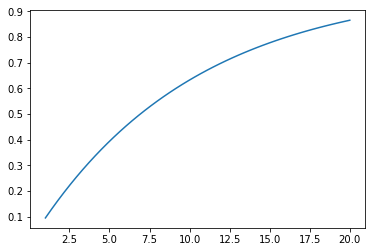

In [57]:
t = np.linspace(1,20)
plt.plot(t,1 - np.exp(-t/tau_steps))

(array([  6.,  10.,   3.,   4.,   2.,   1.,   3.,   4.,   4.,   3.]),
 array([  2.97738153e-04,   9.88650563e-02,   1.97432374e-01,
          2.95999693e-01,   3.94567011e-01,   4.93134329e-01,
          5.91701647e-01,   6.90268965e-01,   7.88836283e-01,
          8.87403602e-01,   9.85970920e-01]),
 <a list of 10 Patch objects>)

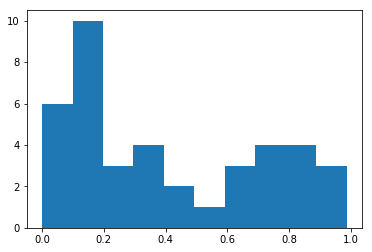

In [58]:
plt.hist(np.random.rand(num_steps))

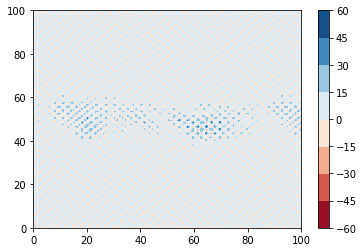

In [59]:
# Demonstrate that we successfully generate a noise field
amp = generate_masked_noise(k_0,l_0,xx,yy,sigma_k,A_0,sigma_y)
plt.contourf(xx,yy,amp,cmap=plt.get_cmap("RdBu"))
plt.colorbar()

In [60]:
# Calculate a slowly varying noise field
time_amp = time_evolving_noise(k_0,l_0,xx,yy,sigma_k,A_0,sigma_y,tau_steps,num_steps)

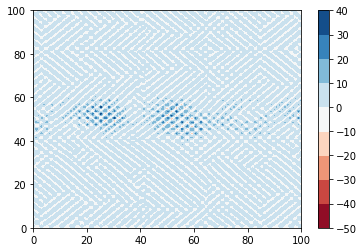

In [61]:
# A bunch of plots below showing a time series 
plt.contourf(xx,yy,time_amp[10][:][:],cmap=plt.get_cmap("RdBu"))
plt.colorbar()

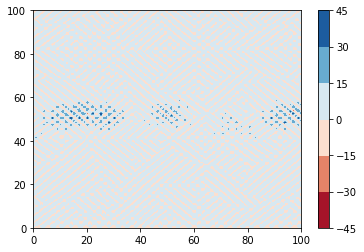

In [62]:
plt.contourf(xx,yy,time_amp[11][:][:],cmap=plt.get_cmap("RdBu"))
plt.colorbar()

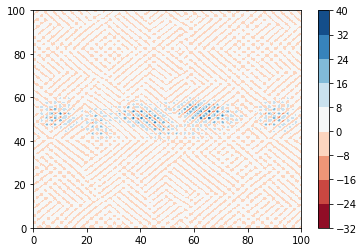

In [63]:
plt.contourf(xx,yy,time_amp[12][:][:],cmap=plt.get_cmap("RdBu"))
plt.colorbar()

In [64]:
# Calculate a stochastic noise field
stoch_amp, t_data = stochastic_noise(k_0,l_0,xx,yy,sigma_k,A_0,sigma_y,tau_steps,num_steps)

In [65]:
print t_data

[ 0.  1.  0.  1.  0.  1.  2.  0.  1.  0.  1.  0.  1.  0.  1.  0.  1.  2.
  0.  1.  0.  1.  0.  1.  2.  0.  1.  0.  1.  0.  1.  2.  3.  0.  1.  2.
  0.  1.  0.  0.]


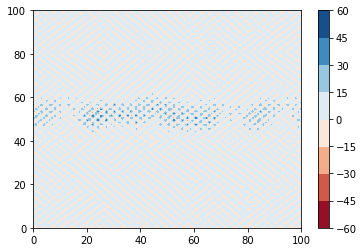

In [66]:
plt.contourf(xx,yy,stoch_amp[2][:][:],cmap=plt.get_cmap("RdBu"))
plt.colorbar()

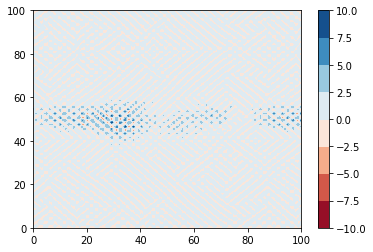

In [67]:
plt.contourf(xx,yy,stoch_amp[6][:][:],cmap=plt.get_cmap("RdBu"))
plt.colorbar()

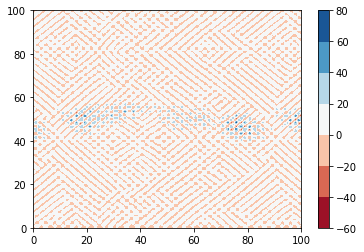

In [68]:
plt.contourf(xx,yy,stoch_amp[7][:][:],cmap=plt.get_cmap("RdBu"))
plt.colorbar()